# Background  
This is a notebook with models for decision tree and K-Nearest Neighbours classification algorithms.
It is divided into 3 main sections with different subsections within each one:
1. Data preprocessing and exploration
2. Preparation for algorithms
2. Decision Tree Algorithm
3. K-Nearest Neighbour Algorithm

## 1. Data Preprocessing and evaluation/exploration

### 1(a) Import the main libraries that you will need

In [1]:
# Install sofware for visualising decision tree
# for mac specifically install homebrew in order to install graphviz. 
# Enter "/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" into commang line terminal
!brew install graphviz  
!pip install graphviz
!pip install pydotplus
!pip install sklearn --upgrade

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> Updated Formulae
amazon-ecs-cli  fonttools       libntlm         mdk             teleport
babel           gdb             libodfgen       mesa            terrahub
bartycrouch     gibo            libwpd          prettier        tile38
cointop         jsdoc3          libwpg          protoc-gen-go   topgrade
elixir          libmtp          mbedtls         serve           vegeta
fibjs           libmwaw         mdds            syncthing
==> Deleted Formulae
js-test-driver

To reinstall 2.40.1, run `brew reinstall graphviz`
Requirement already up-to-date: sklearn in /Users/clairemooney/anaconda3/lib/python3.7/site-packages (0.0)


In [2]:
# general dataframe items
import pandas as pd
import numpy as np
import os

# for graphs
import matplotlib
import matplotlib.pyplot as plt # for histograms
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for feature space diagram



# Sklearn items
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score

# For SBS method
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

# for decision tree
import graphviz 
import pydotplus
from IPython.display import Image
from IPython import display
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# supress warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### 1 (b) Create dataframe and do some data pre-processing
* Create dataframe
* Deal with missing values
* Ensure data is in the correct format for downstream processes
* Ensure values are within an acceptable range for the feature type
* Remove obsolete features (BI-RADS)


In [3]:
# First create dataframe and rename columns accordingly

data = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"
df = pd.read_csv(data, names=["BIRADS", "Age", "Shape", "Margin", "Density", "Severity"])

print(df.shape)
df.head(5)

(961, 6)


,BIRADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [4]:
# Deal with missing values
# Step 1 - replace ? with NaN
df = df.replace('?', np.nan)
df.head(5)



,BIRADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,NaN,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,NaN,1


In [5]:
# Deal with missing values
# Step 2 - check that there are no missing values left in the data and count how many rows contain NaN for each column
print(df.isin(['?']).sum(axis=0))
print("-----------------")
print(df.isna().sum(axis=0))
print("-----------------")

BIRADS      0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64
-----------------
BIRADS       2
Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64
-----------------


In [6]:
# Deal with missing values 
# Step 3 remove rows that have missing values
nomissing = df.dropna(axis = 0, how = 'any')

# check that there are no missing values left in the data
print(nomissing.isin(['?']).sum(axis=0))
print("-----------------")
print(nomissing.isin(['NaN']).sum(axis=0))
print("-----------------")

total_rows = nomissing.Severity.count()
malignant = nomissing.Severity.sum()
benign = nomissing.Severity.count() - nomissing.Severity.sum()

print("Number of rows after removal of missing values: " + str(total_rows))  # count how many rows are left
print("Number of malignant (1) cases: " + str(malignant))  # count how many malignant cases there are ie: number that = 1
print('Number of benign (0) cases: ' + str(benign))

# ensure that the data is balanced
print("Ratio of malignant (1) vs benign (0) = " + str((malignant/total_rows).round(2)) + ":" + str((benign/total_rows).round(2)))



BIRADS      0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64
-----------------
BIRADS      0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64
-----------------
Number of rows after removal of missing values: 830
Number of malignant (1) cases: 403
Number of benign (0) cases: 427
Ratio of malignant (1) vs benign (0) = 0.49:0.51


In [7]:
# Impute missing values
# Step 1 - convert date to numeric data for calculation of frequency and mean

numeric_birads = pd.to_numeric(df['BIRADS'], errors='coerce')
numeric_age = pd.to_numeric(df['Age'], errors='coerce')
numeric_shape = pd.to_numeric(df['Shape'], errors='coerce')
numeric_margin = pd.to_numeric(df['Margin'], errors='coerce')
numeric_density = pd.to_numeric(df['Density'], errors='coerce')
numeric_severity = pd.to_numeric(df['Severity'], errors='coerce')

impute = pd.concat([numeric_birads, numeric_age, numeric_shape, numeric_margin, numeric_density, numeric_severity], axis = 1)

In [8]:
# Impute missing values
# Step 2 - Impute with mean for age and most frequent value for other features 

mean_age = impute.Age.mean()
birads_mostfreq = impute.BIRADS.mode().T[0]
shape_mostfreq = impute.Shape.mode().T[0]
margin_mostfreq = impute.Margin.mode().T[0]
density_mostfreq = impute.Density.mode().T[0]

impute['Age'] = impute['Age'].fillna(mean_age)
impute['BIRADS'] = impute['BIRADS'].fillna(shape_mostfreq)
impute['Shape'] = impute['Shape'].fillna(shape_mostfreq)
impute['Margin'] = impute['Margin'].fillna(shape_mostfreq)
impute['Density'] = impute['Density'].fillna(shape_mostfreq)

# check shape and count how many null values (should be zero after imputation)
print(impute.shape)
print(impute.isna().sum(axis=0))

(961, 6)
BIRADS      0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64


In [9]:
# Get some info on imputation

impute_total_rows = impute.Severity.count()
impute_malignant = impute.Severity.sum()
impute_benign = impute.Severity.count() - impute.Severity.sum()

print("Number of rows after imputation of missing values: " + str(impute_total_rows))  # count how many rows are left
print("Number of malignant (1) cases: " + str(impute_malignant))  # count how many malignant cases there are ie: number that = 1
print('Number of benign (0) cases: ' + str(impute_benign))

# ensure that the data is balanced
print("Ratio of malignant (1) vs benign (0) = " + str((impute_malignant/impute_total_rows).round(2)) + ":" + str((impute_benign/impute_total_rows).round(2)))



Number of rows after imputation of missing values: 961
Number of malignant (1) cases: 445
Number of benign (0) cases: 516
Ratio of malignant (1) vs benign (0) = 0.46:0.54


In [10]:
# check the range of the data to ensure all data points are in correct range
for i, j in zip([nomissing, impute], ['No Missing values', 'Imputed Values']):
    print(j)
    print("Minimum")
    print(i.min())
    print("Maximum")
    print(i.max())
    print("-------------------")
    


No Missing values
Minimum
BIRADS       0.0
Age         18.0
Shape        1.0
Margin       1.0
Density      1.0
Severity     0.0
dtype: float64
Maximum
BIRADS       6.0
Age         96.0
Shape        4.0
Margin       5.0
Density      4.0
Severity     1.0
dtype: float64
-------------------
Imputed Values
Minimum
BIRADS       0.0
Age         18.0
Shape        1.0
Margin       1.0
Density      1.0
Severity     0.0
dtype: float64
Maximum
BIRADS      55.0
Age         96.0
Shape        4.0
Margin       5.0
Density      4.0
Severity     1.0
dtype: float64
-------------------


In [11]:
# BIRADS should only be in the range of 0-6 hence only keep rows where the value for BIRADS is < 7 
# to ensure that valid entries are used 

# change date to integer
nomissing = nomissing.astype(int)
impute = impute.astype(int)

# keep only Birads < 7
nomissing = nomissing[nomissing['BIRADS'] < 7]
impute = impute[impute['BIRADS'] < 7]

print(nomissing.shape)
print(impute.shape)

(829, 6)
(960, 6)


The data is now in an acceptable and useable format for evaulation and for downstream use in the Decision Tree and K-Nearest Neighbours algorithms

In [12]:
# BIRADs is not actually a predictive feature so it should be removed from the dataframe

nomissing = nomissing.drop(['BIRADS'], axis=1)
impute = impute.drop(['BIRADS'], axis=1)

### 1(c) Data Exploration
* Run some descriptive statistics
* Generate some individual histograms
* Create a correation matrix to look for differences in malignant vs benign
* Visualise the feature space

In [13]:
# descriptive statistics - mean, median and std dev of age 
for i, j in zip([nomissing, impute], ["No Missing values", 'With imputed values']):
    print(j)
    print("The mean age is: " + str(i.Age.mean()) + " +/- " + str(i.Age.std()))
    print("The median age is: " + str(i.Age.median()))
    print("The maximum age is: " + str(i.Age.max()))
    print("The minimum age is: " + str(i.Age.min()))
    print('--------------------------')

No Missing values
The mean age is: 55.79372738238842 +/- 14.676698125025469
The median age is: 57.0
The maximum age is: 96
The minimum age is: 18
--------------------------
With imputed values
The mean age is: 55.494791666666664 +/- 14.44669371479823
The median age is: 57.0
The maximum age is: 96
The minimum age is: 18
--------------------------


In [14]:
# descriptive statistics - least / most frequent occurences fro categorical data
columns = ['Shape', 'Margin', 'Density']

for dataset, label in zip([nomissing, impute], ["No Missing values", 'With imputed values']):
    print(label)

    for column in columns:
        Freq = dataset[column].value_counts()
        print(Freq)
    print("---------------------")


No Missing values
4    378
1    190
2    180
3     81
Name: Shape, dtype: int64
1    320
4    254
5    127
3    105
2     23
Name: Margin, dtype: int64
3    754
2     56
1     11
4      8
Name: Density, dtype: int64
---------------------
With imputed values
4    430
1    224
2    211
3     95
Name: Shape, dtype: int64
1    357
4    328
5    136
3    115
2     24
Name: Margin, dtype: int64
3    797
4     88
2     59
1     16
Name: Density, dtype: int64
---------------------


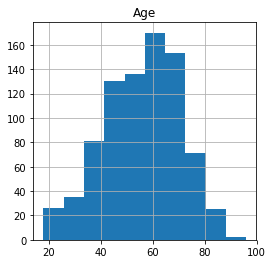

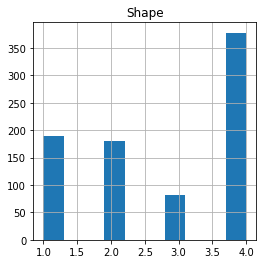

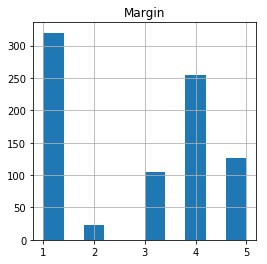

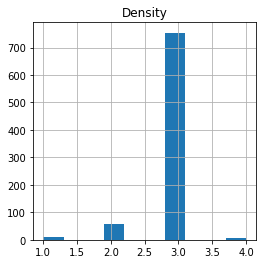

In [15]:
# individual histograms 

nomissing.hist(column=['Age'], figsize=(4,4))
nomissing.hist(column=['Shape'], figsize=(4,4))
nomissing.hist(column=['Margin'], figsize=(4,4))
nomissing.hist(column=['Density'], figsize=(4,4))
plt.show()

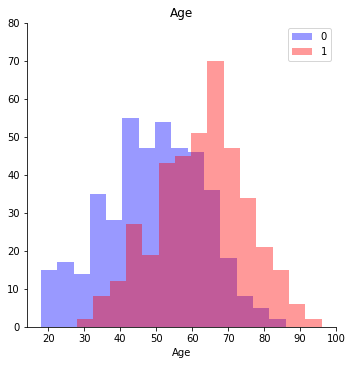

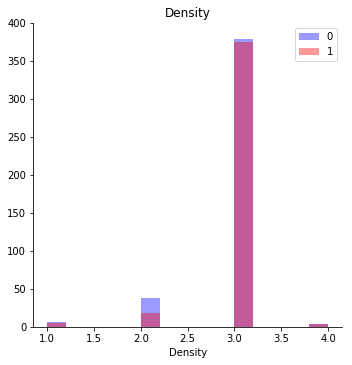

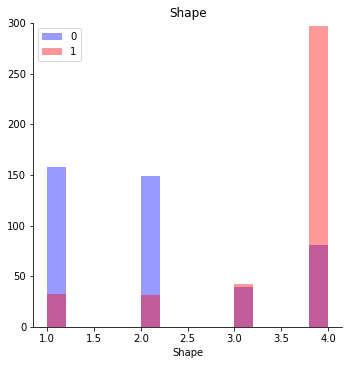

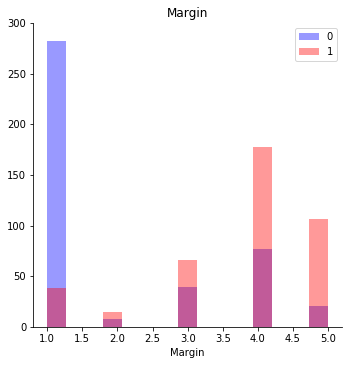

In [16]:
# multiple Histograms to look at the frequency of the data in separate classifiers - Dataset A (nomissing)

columns = ['Age', 'Density', 'Shape', 'Margin']

y_max = {column: val for column, val in zip(columns, [80, 400, 300, 300])}

for column in columns: 
    g = sns.FacetGrid(nomissing, hue='Severity', palette={0 : "b", 1 : "r"}, size=5)
    g.map(sns.distplot, column, kde=False, bins=15)
    plt.legend()
    plt.title(column)
    plt.ylim(0, y_max.get(column))



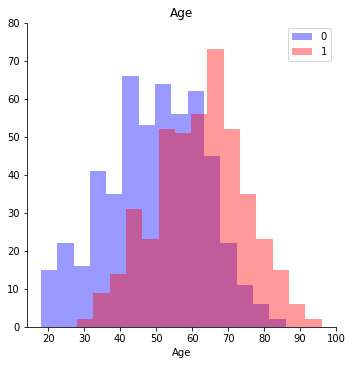

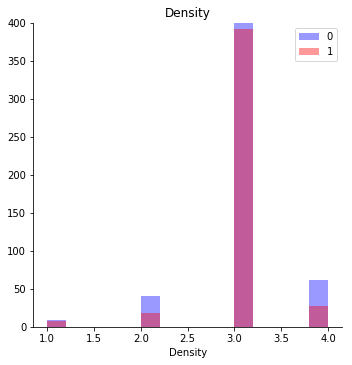

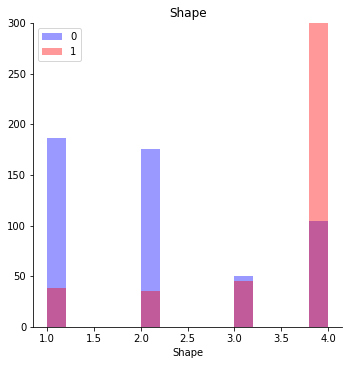

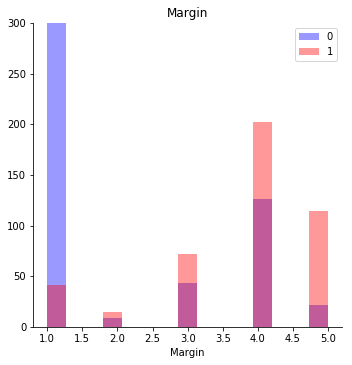

In [17]:
# multiple Histograms to look at the frequency of the data in separate classifiers - Dataset B (impute)

columns = ['Age', 'Density', 'Shape', 'Margin']

y_max = {column: val for column, val in zip(columns, [80, 400, 300, 300])}

for column in columns: 
    g = sns.FacetGrid(impute, hue='Severity', palette={0 : "b", 1 : "r"}, size=5)
    g.map(sns.distplot, column, kde=False, bins=15)
    plt.legend()
    plt.title(column)
    plt.ylim(0, y_max.get(column))




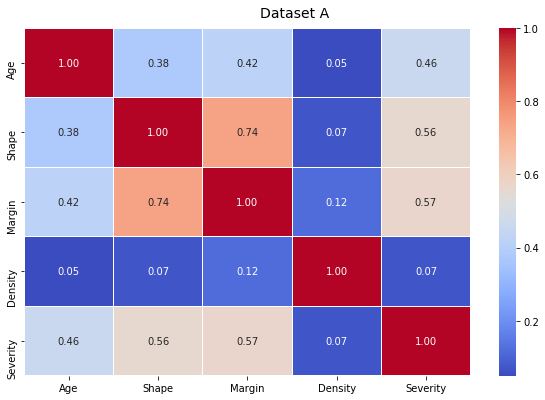

In [18]:
# Correlation Heatmap - Dataset A
f, ax = plt.subplots(figsize=(10, 6))
corr = nomissing.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Dataset A', fontsize=14)



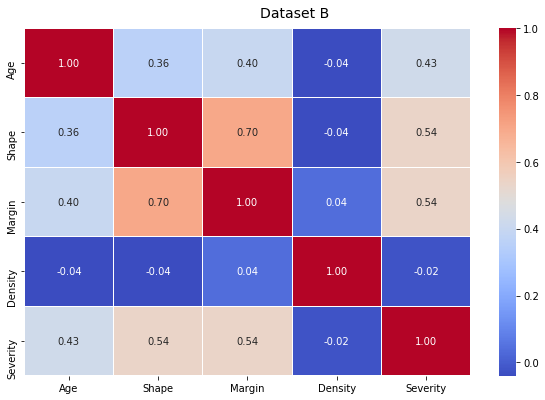

In [19]:
# Correlation Heatmap - Dataset B

f, ax = plt.subplots(figsize=(10, 6))
corr = impute.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Dataset B', fontsize=14)

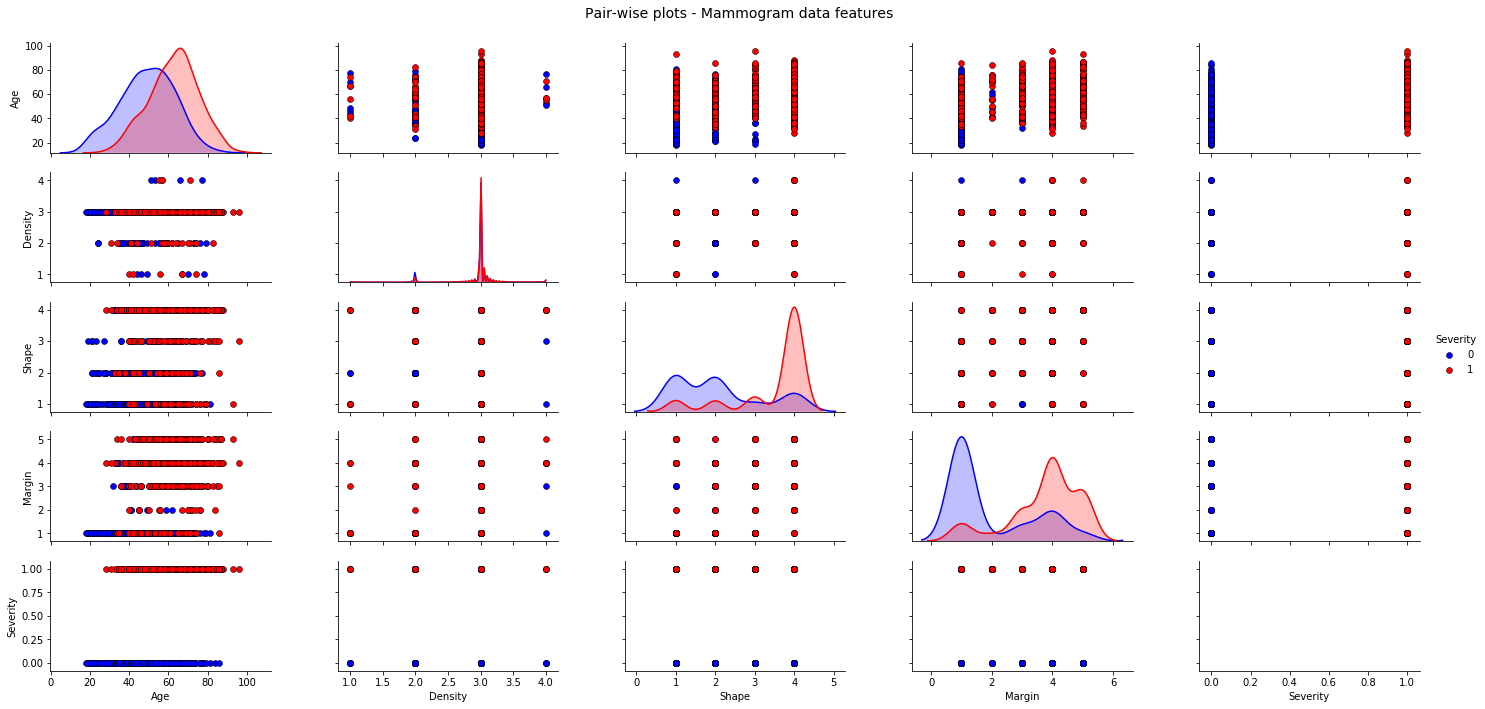

In [20]:
# Correlation Matrix look for difference in malignant vs benign - Dataset A


cols = ['Age', 'Density', 'Shape', 'Margin', 'Severity']
pp = sns.pairplot(nomissing[cols], hue='Severity', height=2, aspect=2, 
                  palette={0 : "b", 1 : "r"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pair-wise plots - Mammogram data features', fontsize=14)



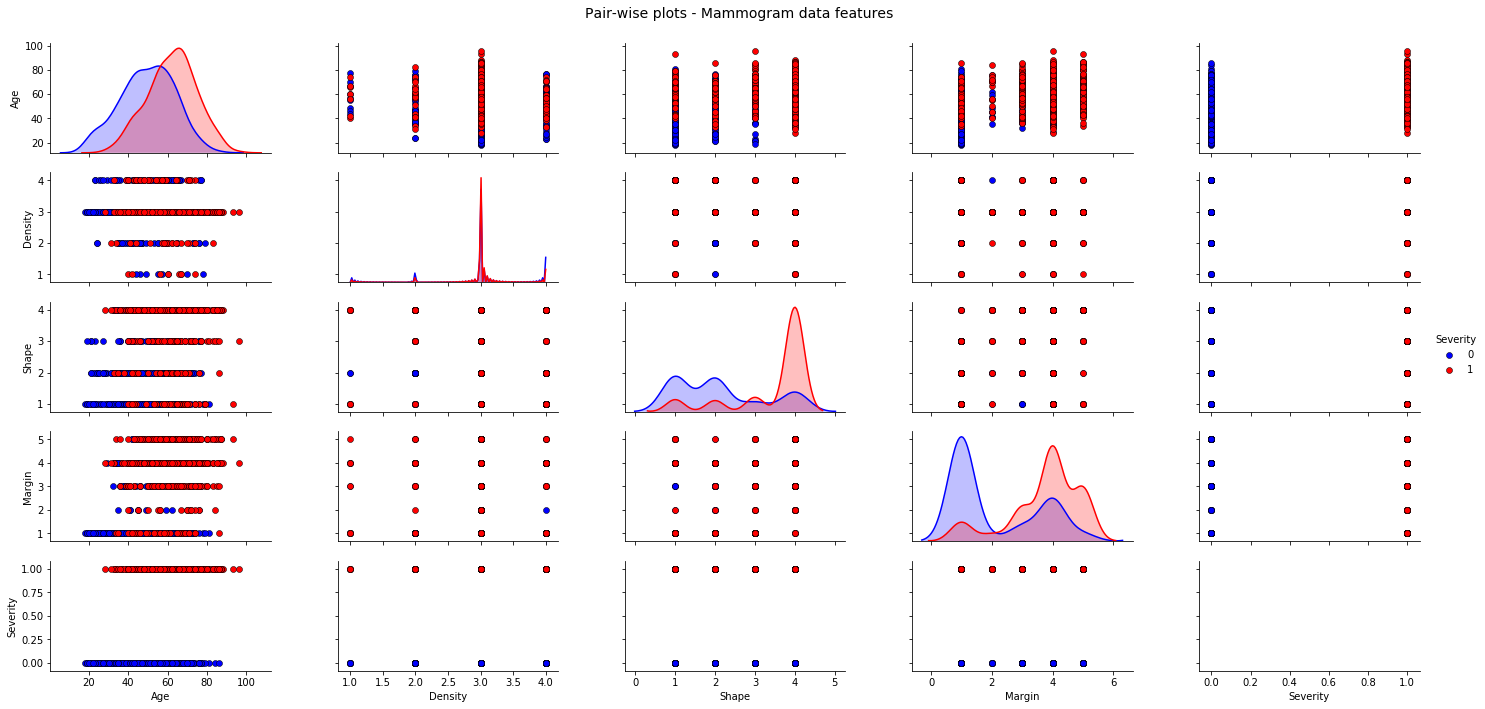

In [21]:
# Correlation Matrix look for difference in malignant vs benign - Dataset B

# Dataset B
cols = ['Age', 'Density', 'Shape', 'Margin', 'Severity']
pp = sns.pairplot(impute[cols], hue='Severity', height=2, aspect=2, 
                  palette={0 : "b", 1 : "r"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pair-wise plots - Mammogram data features', fontsize=14)

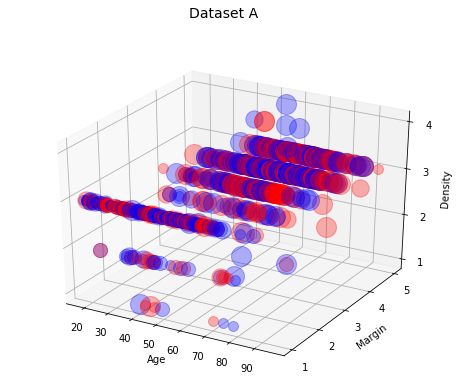

In [22]:
# Visualizing 4-D mix data using bubble charts
# leveraging the concepts of hue, size and depth
# reference adapted from https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57


# Dataset A

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
t = fig.suptitle('Dataset A', fontsize=14)

xs = list(nomissing['Age'])
ys = list(nomissing['Margin'])
zs = list(nomissing['Density'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]

ss = list(nomissing['Shape'])

colormap = {0:'blue', 1:'red'}
colors = [colormap.get(severity, 'magenta') for severity in list(impute['Severity'])]

for data, color, size in zip(data_points, colors, ss):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.3, c=color, edgecolors=None, s=size*100)

ax.set_xlabel('Age')
ax.set_ylabel('Margin')
ax.set_zlabel('Density')
ax.set_yticks([1,2,3,4,5], minor=False)
ax.set_zticks([1,2,3,4], minor=False)
ax.set_facecolor((1, 1, 1))

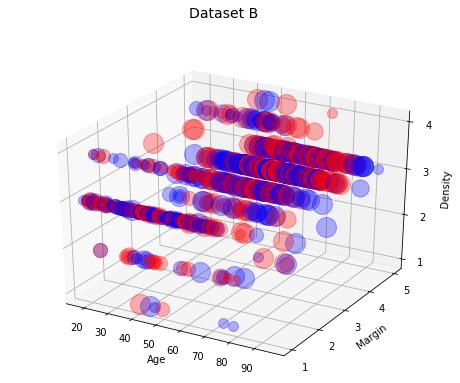

In [23]:
# Visualizing 4-D mix data using bubble charts
# leveraging the concepts of hue, size and depth
# reference adapted from https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57


# Dataset B

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
t = fig.suptitle('Dataset B', fontsize=14)

xs = list(impute['Age'])
ys = list(impute['Margin'])
zs = list(impute['Density'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]

ss = list(impute['Shape'])

colormap = {0:'blue', 1:'red'}
colors = [colormap.get(severity, 'magenta') for severity in list(nomissing['Severity'])]

for data, color, size in zip(data_points, colors, ss):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.3, c=color, edgecolors=None, s=size*100)

ax.set_xlabel('Age')
ax.set_ylabel('Margin')
ax.set_zlabel('Density')
ax.set_yticks([1,2,3,4,5], minor=False)
ax.set_zticks([1,2,3,4], minor=False)
ax.set_facecolor((1, 1, 1))

## 2. Preparation for algorithms

### 2(a) Import everything you need from sklearn and set up image and graph defaults

In [24]:
from __future__ import division, print_function, unicode_literals # To support both python 2 and python 3

# to make outputs from the notebook stable across runs
np.random.seed(42)

# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

### 2(b) Partition dataset into training and test sets

In [25]:
# partition processed data (with missing removed and imputed data) into training and test sets

X, y = nomissing.iloc[:, 0:4].values, nomissing.iloc[:, -1].values # -1 indexing

X_imputed, y_imputed = impute.iloc[:, 0:4].values, impute.iloc[:, -1].values # -1 indexing

# standard test size = 0.33, stratify the data to ensure balanced categories in training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1, stratify=y) 

X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = train_test_split(X_imputed, y_imputed, test_size=0.33, random_state=1, stratify=y_imputed) 



In [26]:
# check that the splitting was completed correctly 
print(nomissing.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.sum()) # to ensure that the training data is half benign (0) and half malignant (1) cases

(829, 5)
(555, 4)
(274, 4)
(555,)
(274,)
269


Data is now divided into test set (33%) and training set (67%)

## 3. Decision Tree

### 3(a) Find out the best depth for the tree (hyperparameter tuning)

The optimal depth is 4


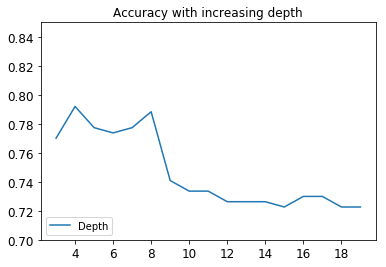

In [27]:
%matplotlib inline

# create function to test for a range of tree depths

def plotvector_dt(XTrain, yTrain, XTest, yTest):
    results = []
    
# test out different depths for the tree between 1-20

    for n in range(3,20):
        dt = DecisionTreeClassifier(max_depth=n, random_state=42)
        dt.fit(XTrain, yTrain)
        preds = dt.predict(XTest)
        accuracy = dt.score(XTest, yTest)
        results.append([n, accuracy])
 
    results = np.array(results)
    return(results)


pltvector1 = plotvector_dt(X_train, y_train, X_test, y_test)

# retrieve printout of depth with the highest accuracy
optimal_d = pltvector1[np.argmax(pltvector1[:, 1])][0]
print ("The optimal depth is %d" % optimal_d)

# create a graph of the results
line1 = plt.plot(pltvector1[:,0], pltvector1[:,1], label="Depth")

plt.legend(loc=3)
plt.ylim(0.7, 0.85)
plt.title("Accuracy with increasing depth")
plt.show()

The optimal depth is 3


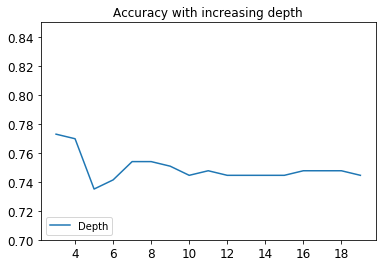

In [28]:
%matplotlib inline

# repeat step above for imputed data

def plotvector_dt(XTrain, yTrain, XTest, yTest):
    results_imputed = []
    
# test out different depths for the tree between 1-20

    for n in range(3,20):
        dt_imputed = DecisionTreeClassifier(max_depth=n, random_state=42)
        dt_imputed.fit(XTrain, yTrain)
        preds_imputed = dt_imputed.predict(XTest)
        accuracy_imputed = dt_imputed.score(XTest, yTest)
        results_imputed.append([n, accuracy_imputed])
 
    results_imputed = np.array(results_imputed)
    return(results_imputed)


pltvector1_imputed = plotvector_dt(X_train_imputed, y_train_imputed, X_test_imputed, y_test_imputed)

# retrieve printout of depth with the highest accuracy
optimal_d_imputed = pltvector1_imputed[np.argmax(pltvector1_imputed[:, 1])][0]
print ("The optimal depth is %d" % optimal_d_imputed)

# create a graph of the results
line2 = plt.plot(pltvector1_imputed[:,0], pltvector1_imputed[:,1], label="Depth")

plt.legend(loc=3)
plt.ylim(0.7, 0.85)
plt.title("Accuracy with increasing depth")
plt.show()

### 3(b) Generate a Decision Tree Classifer 

In [29]:
# Create decision tree using the optimal depth from the pevious step and test the accuracy 

dt = DecisionTreeClassifier(max_depth=optimal_d, random_state=42)
dt_imputed = DecisionTreeClassifier(max_depth=optimal_d_imputed, random_state=42)



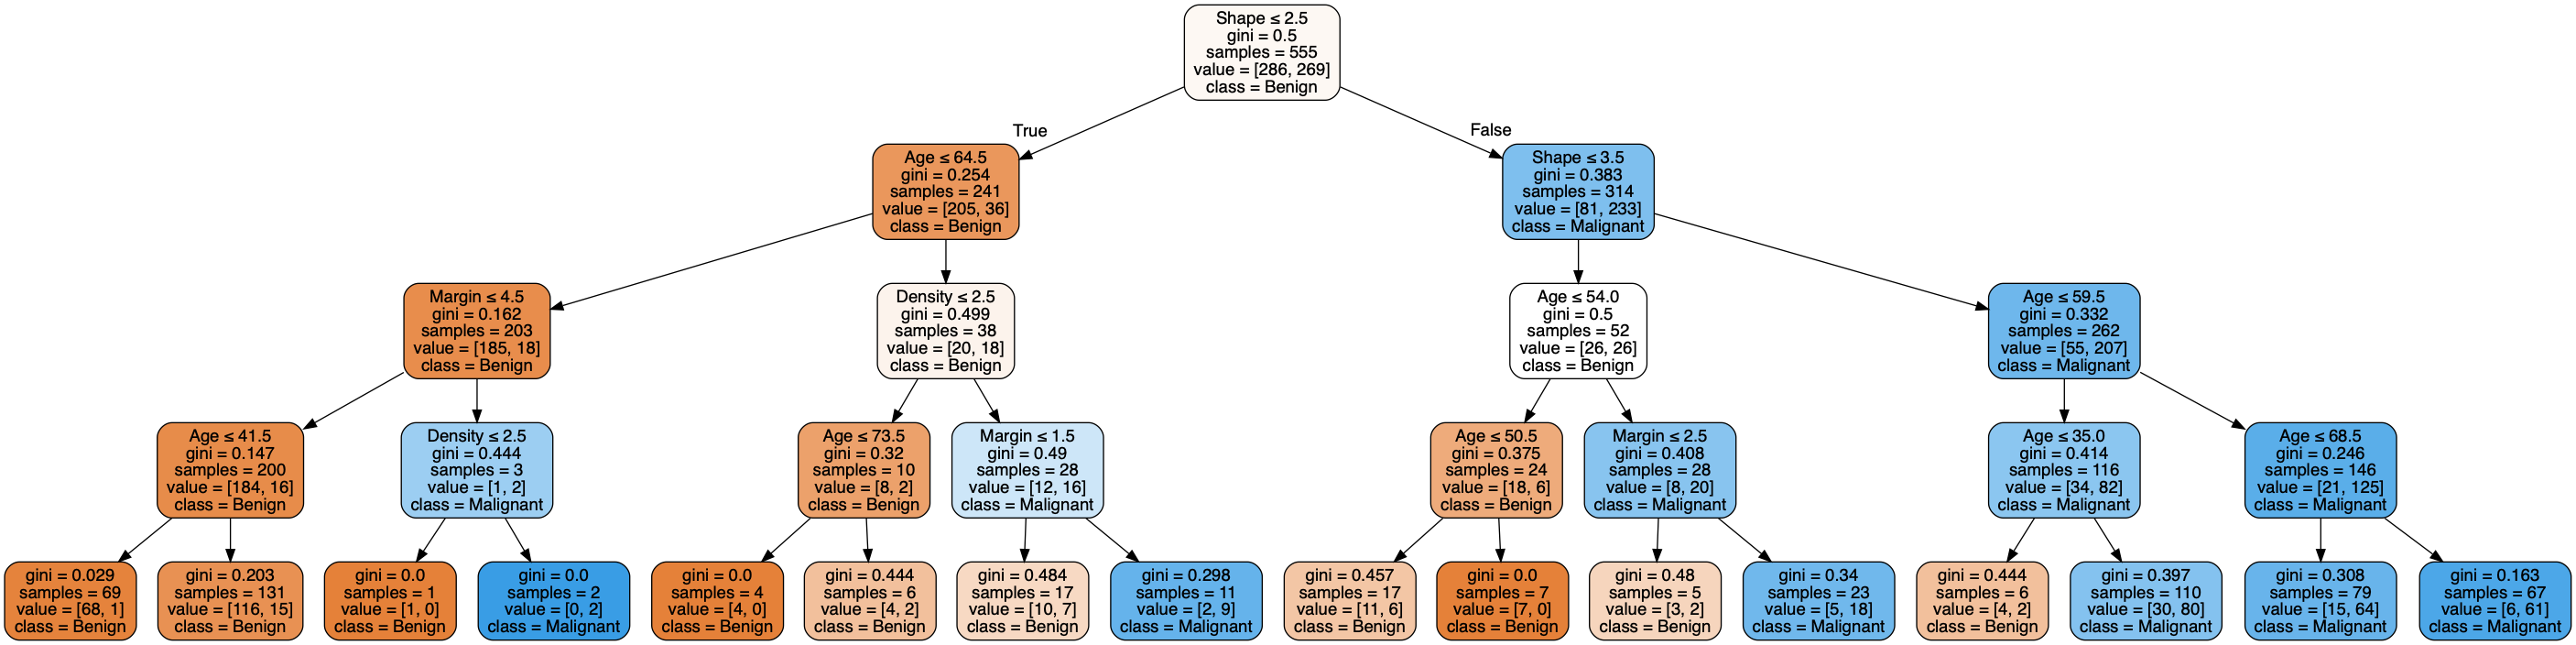

In [30]:
# create decision tree

dt.fit(X_train, y_train)
dot_data=StringIO()
dot_data = export_graphviz(dt, out_file = None, feature_names=nomissing.columns[:4], class_names=['Benign', 'Malignant'], 
                filled=True, rounded=True, special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


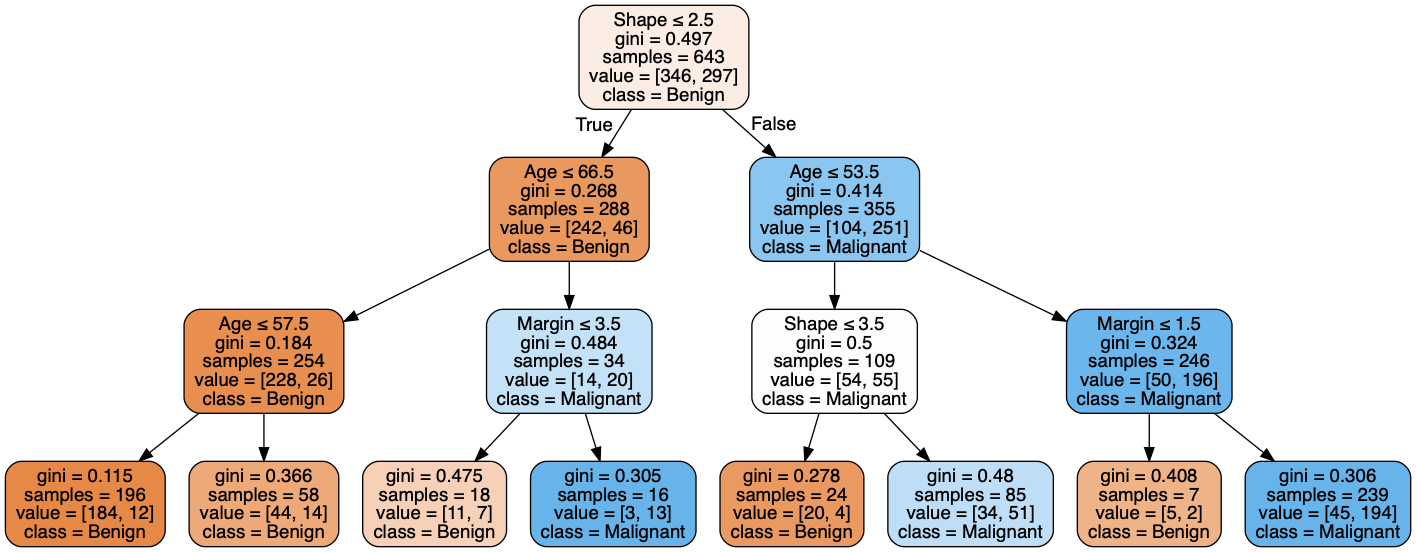

In [31]:
# create decision tree with imputed values

dt_imputed.fit(X_train_imputed, y_train_imputed)
dot_data_imputed = export_graphviz(dt_imputed, out_file = None, feature_names=impute.columns[:4], class_names=['Benign', 'Malignant'], 
                filled=True, rounded=True, special_characters=True) 

graph_imputed = pydotplus.graph_from_dot_data(dot_data_imputed)
Image(graph_imputed.create_png())



### 3(c) Model Evaluation
* Confusion Matrix 
* Area under the curve
* F1, precision and recall
* 5-fold cross validation

-------
With dropped values
[[106  27]
 [ 30 111]]
-------
Imputed values
[[116  31]
 [ 41 129]]


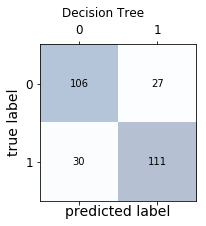

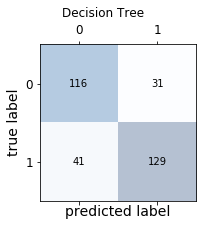

In [32]:
# Create a simple and more visually appealing confusion matrix

dt.fit(X_train, y_train)
dt_imputed.fit(X_train_imputed, y_train_imputed)

print('-------')
print('With dropped values')
y_pred = dt.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1,0])
print(confmat)

print('-------')
print('Imputed values')
y_pred_imputed = dt_imputed.predict(X_test_imputed)
confmat_imputed = confusion_matrix(y_true=y_test_imputed, y_pred=y_pred_imputed, labels=[1,0])
print(confmat_imputed)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.suptitle('Decision Tree', y=1, va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat_imputed, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_imputed.shape[0]):
    for j in range(confmat_imputed.shape[1]):
        ax.text(x=j, y=i, s=confmat_imputed[i, j], va='center', ha='center')

plt.suptitle('Decision Tree', y=1, va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()

plt.show()

In [33]:
# Model evaluation - dropped missing dataset

dt.fit(X_train, y_train)
accuracy = dt.score(X_test, y_test)
print ("Accuracy for DT with no missing values = " + str((accuracy.round(3))))

y_pred = dt.predict(X_test)
print('Precision for DT with no missing values: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall for DT with no missing values: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1 for DT with no missing values: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


Accuracy for DT with no missing values = 0.792
Precision for DT with no missing values: 0.779
Recall for DT with no missing values: 0.797
F1 for DT with no missing values: 0.788


In [34]:
# Model evaluation - imputed dataset

dt_imputed.fit(X_train_imputed, y_train_imputed)
accuracy_imputed = dt_imputed.score(X_test_imputed, y_test_imputed)
print ("Accuracy for DT with imputed values = " + str((accuracy_imputed.round(3))))

y_pred_imputed = dt_imputed.predict(X_test_imputed)
print('Precision for DT with imputed values: %.3f' % precision_score(y_true=y_test_imputed, y_pred=y_pred_imputed))
print('Recall for DT with imputed values: %.3f' % recall_score(y_true=y_test_imputed, y_pred=y_pred_imputed))
print('F1 for DT with imputed values: %.3f' % f1_score(y_true=y_test_imputed, y_pred=y_pred_imputed))


Accuracy for DT with imputed values = 0.773
Precision for DT with imputed values: 0.739
Recall for DT with imputed values: 0.789
F1 for DT with imputed values: 0.763


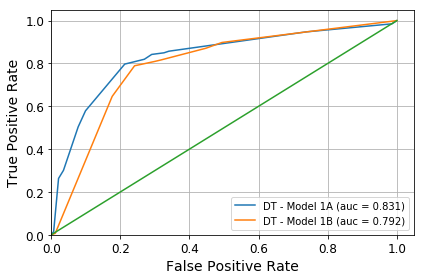

In [35]:
# create a ROC curve and caluclate the area under the curve

label = "DT - Model 1A"
y_pred = dt.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % (label, roc_auc))

label = "DT - Model 1B"
y_pred = dt_imputed.fit(X_train_imputed, y_train_imputed).predict_proba(X_test_imputed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=y_test_imputed, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % (label, roc_auc))


plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1]) 
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.show()


In [36]:
# Cross validation
    
cv_tests = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
dt_test_results = []

print("Data with missing values deleted")
print("       ")
for test in cv_tests:
    dt_scores = cross_val_score(dt, X, y, cv=5, scoring=test)
    dt_test_results.append(dt_scores)
    print("5-fold " + test + " :  %0.3f (+/- %0.2f)" % (dt_scores.mean(), dt_scores.std() * 2))

print("-------------------------")
print("Data with imputed values")
print("       ")

dt_test_results_imputed = []

for test in cv_tests:
    dt_imputed_scores = cross_val_score(dt_imputed, X_imputed, y_imputed, cv=5, scoring=test)
    dt_test_results_imputed.append(dt_imputed_scores)
    print("5-fold " + test + " :  %0.3f (+/- %0.2f)" % (dt_imputed_scores.mean(), dt_imputed_scores.std() * 2))
    


Data with missing values deleted
       
5-fold accuracy :  0.788 (+/- 0.05)
5-fold precision :  0.766 (+/- 0.06)
5-fold recall :  0.813 (+/- 0.13)
5-fold f1 :  0.787 (+/- 0.06)
5-fold roc_auc :  0.835 (+/- 0.03)
-------------------------
Data with imputed values
       
5-fold accuracy :  0.782 (+/- 0.03)
5-fold precision :  0.725 (+/- 0.05)
5-fold recall :  0.858 (+/- 0.08)
5-fold f1 :  0.785 (+/- 0.03)
5-fold roc_auc :  0.829 (+/- 0.03)


## 4. K-Nearest Neighbour Algorithm

### (a) Select best K-number

First create a pipeline for the K-nearest neighbours algorithm and method to select for the highest accuracy

The optimal number of neighbors is 23


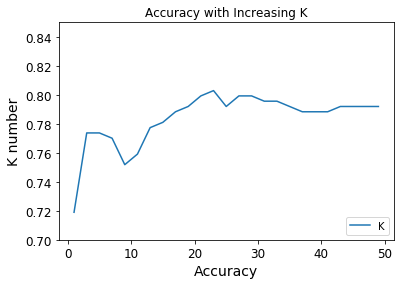

In [37]:
%matplotlib inline


def plotvector(XTrain, yTrain, XTest, yTest, weights):
    results = []
    
# test out different K numbers between 1-50, taking every second number eg: 1, 3, 5. CHoose odd number to avoid a draw

    for n in range(1,50,2):
        pipe_knn_test = Pipeline([('mms', MinMaxScaler()), ('pca', PCA(random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=n, weights='uniform', metric='euclidean'))]) # test pipeline
        pipe_knn_test.fit(XTrain, yTrain)
        preds = pipe_knn_test.predict(XTest)
        accuracy = pipe_knn_test.score(XTest, yTest)
        results.append([n, accuracy])
 
    results = np.array(results)
    return(results)

pltvector1 = plotvector(X_train, y_train, X_test, y_test, weights="uniform")


# retrieve printout of K with the highest accuracy
optimal_k = int(pltvector1[np.argmax(pltvector1[:, 1])][0])

print ("The optimal number of neighbors is %d" % optimal_k)

# create a graph of the results
line1 = plt.plot(pltvector1[:,0], pltvector1[:,1], label="K")

plt.legend(loc=4)
plt.ylim(0.7, 0.85)
plt.title("Accuracy with Increasing K")
plt.xlabel("Accuracy")
plt.ylabel("K number")
plt.show()

The optimal number of neighbors is 13


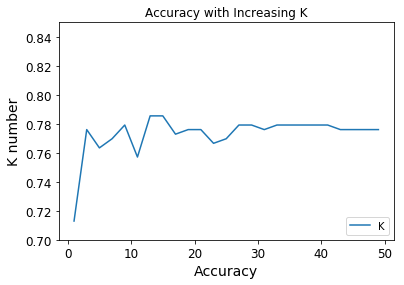

In [38]:
%matplotlib inline


def plotvector(XTrain, yTrain, XTest, yTest, weights):
    results_imputed = []
    
# test out different K numbers between 1-50, taking every second number eg: 1, 3, 5. CHoose odd number to avoid a draw

    for n in range(1,50,2):
        pipe_knn_test_imputed = Pipeline([('mms', MinMaxScaler()), ('pca', PCA(random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=n, weights='uniform', metric='euclidean'))]) # test pipeline
        pipe_knn_test_imputed.fit(XTrain, yTrain)
        preds_imputed = pipe_knn_test_imputed.predict(XTest)
        accuracy_imputed = pipe_knn_test_imputed.score(XTest, yTest)
        results_imputed.append([n, accuracy_imputed])
 
    results_imputed = np.array(results_imputed)
    return(results_imputed)

pltvector1_imputed = plotvector(X_train_imputed, y_train_imputed, X_test_imputed, y_test_imputed, weights="uniform")


# retrieve printout of K with the highest accuracy
optimal_k_imputed = int(pltvector1_imputed[np.argmax(pltvector1_imputed[:, 1])][0])

print ("The optimal number of neighbors is %d" % optimal_k_imputed)

# create a graph of the results
line1_imputed = plt.plot(pltvector1_imputed[:,0], pltvector1_imputed[:,1], label="K")

plt.legend(loc=4)
plt.ylim(0.7, 0.85)
plt.title("Accuracy with Increasing K")
plt.xlabel("Accuracy")
plt.ylabel("K number")
plt.show()

 Then evaluate the model that uses the optimised k-neighbours using the following evaluators:  
* confusion matrix
* 5-fold cross validation
* Precsion, Recall and F1 scores

In [39]:
# Create the optimised kNN pipelines for non-imputed and imputed datasets 

pipe_knn_optimal = Pipeline([('mms', MinMaxScaler()), ('pca', PCA(random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k, weights='uniform', metric='euclidean'))])

pipe_knn_optimal_imputed = Pipeline([('mms', MinMaxScaler()), ('pca', PCA(random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k_imputed, weights='uniform', metric='euclidean'))])


-------
With dropped values
[[114  27]
 [ 27 106]]
-------
Imputed values
[[131  39]
 [ 29 118]]


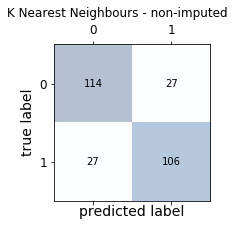

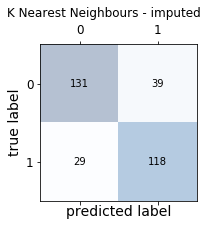

In [40]:
# Create a simple and more visually appealing confusion matrix

pipe_knn_optimal.fit(X_train, y_train)
pipe_knn_optimal_imputed.fit(X_train_imputed, y_train_imputed)

print('-------')
print('With dropped values')
y_pred = pipe_knn_optimal.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('-------')
print('Imputed values')
y_pred_imputed = pipe_knn_optimal_imputed.predict(X_test_imputed)
confmat_imputed = confusion_matrix(y_true=y_test_imputed, y_pred=y_pred_imputed)
print(confmat_imputed)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.suptitle('K Nearest Neighbours - non-imputed', y=1, va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat_imputed, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_imputed.shape[0]):
    for j in range(confmat_imputed.shape[1]):
        ax.text(x=j, y=i, s=confmat_imputed[i, j], va='center', ha='center')

plt.suptitle('K Nearest Neighbours - imputed', y=1, va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()

plt.show()

In [41]:
# Generate the Precision, Recall and F1 scores for the model

pipe_knn_optimal.fit(X_train, y_train)
accuracy = pipe_knn_optimal.score(X_test, y_test)
print ("Accuracy for KNN non-imputed = " + str((accuracy.round(3))))

y_pred = pipe_knn_optimal.predict(X_test)
print('Precision for KNN non-imputed: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall for KNN non-imputed: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1 for KNN non-imputed: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Accuracy for KNN non-imputed = 0.803
Precision for KNN non-imputed: 0.797
Recall for KNN non-imputed: 0.797
F1 for KNN non-imputed: 0.797


In [42]:
pipe_knn_optimal_imputed.fit(X_train_imputed, y_train_imputed)
accuracy_imputed = pipe_knn_optimal_imputed.score(X_test_imputed, y_test_imputed)
print ("Accuracy for KNN imputed = " + str((accuracy_imputed.round(3))))

y_pred_imputed = pipe_knn_optimal_imputed.predict(X_test_imputed)
print('Precision for KNN imputed: %.3f' % precision_score(y_true=y_test_imputed, y_pred=y_pred_imputed))
print('Recall for KNN imputed: %.3f' % recall_score(y_true=y_test_imputed, y_pred=y_pred_imputed))
print('F1 for KNN imputed: %.3f' % f1_score(y_true=y_test_imputed, y_pred=y_pred_imputed))

Accuracy for KNN imputed = 0.785
Precision for KNN imputed: 0.752
Recall for KNN imputed: 0.803
F1 for KNN imputed: 0.776


In [43]:
# Perform 5-fold cross validation

cv_tests = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
knn_test_results = []

print("Data with missing values deleted")
print("       ")
for test in cv_tests:
    knn_scores = cross_val_score(pipe_knn_optimal, X, y, cv=5, scoring=test)
    knn_test_results.append(knn_scores)
    print("5-fold " + test + " :  %0.3f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

print("-------------------------")
print("Data with imputed values")
print("       ")

knn_test_results_imputed = []

for test in cv_tests:
    knn_imputed_scores = cross_val_score(pipe_knn_optimal_imputed, X_imputed, y_imputed, cv=5, scoring=test)
    knn_test_results_imputed.append(knn_imputed_scores)
    print("5-fold " + test + " :  %0.3f (+/- %0.2f)" % (knn_imputed_scores.mean(), knn_imputed_scores.std() * 2))

Data with missing values deleted
       
5-fold accuracy :  0.796 (+/- 0.03)
5-fold precision :  0.765 (+/- 0.04)
5-fold recall :  0.838 (+/- 0.09)
5-fold f1 :  0.799 (+/- 0.04)
5-fold roc_auc :  0.848 (+/- 0.06)
-------------------------
Data with imputed values
       
5-fold accuracy :  0.774 (+/- 0.04)
5-fold precision :  0.732 (+/- 0.03)
5-fold recall :  0.808 (+/- 0.12)
5-fold f1 :  0.767 (+/- 0.05)
5-fold roc_auc :  0.836 (+/- 0.04)


### 4(c) Feature Selection
The model may perform better with less features hence check to see if the features can be reduced

In [44]:
# Sequentional Backwards Selection - reduces the number of features each time and assesses the effect on accuracy

# do first for dropped missing data dataset
# Create SBS method

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.33, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score


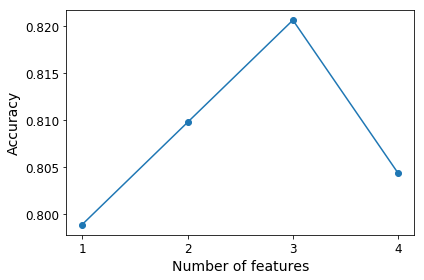

In [45]:
%matplotlib inline

pipe_knn_optimal = Pipeline([('mms', MinMaxScaler()), ('pca', PCA(random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k, weights='uniform', metric='euclidean'))])

# selecting features
sbs = SBS(pipe_knn_optimal, k_features=1)

sbs.fit(X_train, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.xticks(np.arange(1, 5, step=1))
plt.tight_layout()
plt.show()

In [46]:
sbs.subsets_

[(0, 1, 2, 3), (0, 1, 3), (0, 1), (1,)]

In [47]:
# distinguish which features are the most predictive 
k5=list(sbs.subsets_[1])
print (k5)

feature_labels = nomissing.columns[0:5]
print (feature_labels[k5])

[0, 1, 3]
Index(['Age', 'Shape', 'Density'], dtype='object')


From the feature selection we can see that **Age**, **Shape** and **Density** are the most predictive features



In [48]:
# then for imputed dataset 

class SBS_imputed():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.33, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)

        dim = X_train_imputed.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train_imputed, y_train_imputed, 
                                 X_test_imputed, y_test_imputed, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train_imputed, y_train_imputed, 
                                         X_test_imputed, y_test_imputed, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train_imputed, y_train_imputed, X_test_imputed, y_test_imputed, indices):
        self.estimator.fit(X_train_imputed[:, indices], y_train_imputed)
        y_pred = self.estimator.predict(X_test_imputed[:, indices])
        score = self.scoring(y_test_imputed, y_pred)
        return score

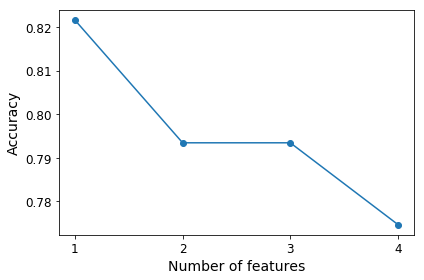

In [49]:
%matplotlib inline

pipe_knn_optimal_imputed = Pipeline([('mms', MinMaxScaler()), ('pca', PCA(random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k_imputed, weights='uniform', metric='euclidean'))])

# selecting features
sbs_imputed = SBS_imputed(pipe_knn_optimal_imputed, k_features=1)

sbs_imputed.fit(X_train_imputed, y_train_imputed)

# plotting performance of feature subsets
k_feat_imputed = [len(k) for k in sbs_imputed.subsets_]

plt.plot(k_feat_imputed, sbs_imputed.scores_, marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.xticks(np.arange(1, 5, step=1))
plt.tight_layout()
plt.show()

In [50]:
sbs_imputed.subsets_

[(0, 1, 2, 3), (0, 1, 2), (0, 1), (1,)]

In [51]:
# distinguish which features are the most predictive 
k5_imputed=list(sbs_imputed.subsets_[3])
print (k5_imputed)

feature_labels = impute.columns[0:5]
print (feature_labels[k5_imputed])

[1]
Index(['Shape'], dtype='object')


### 4(d) Use information from steps (b) and (c) to create a 3-feature model

In [52]:
# First create new dataframe with most predictive features and the class label column

knn_features = nomissing[["Age", "Shape", "Density",'Severity']]
knn_features_imputed = nomissing[["Shape","Severity"]]


In [53]:
# separate into training and test data
X_2, y_2 = knn_features.iloc[:, 0:3].values, knn_features.iloc[:, -1].values # -1 indexing
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.33, random_state=1, stratify=y_2) # standard test size = 0.33

X_2_imputed, y_2_imputed = knn_features_imputed.iloc[:, 0:1].values, knn_features_imputed.iloc[:, -1].values # -1 indexing
X_train_2_imputed, X_test_2_imputed, y_train_2_imputed, y_test_2_imputed = train_test_split(X_2_imputed, y_2_imputed, test_size=0.33, random_state=1, stratify=y_2)

Evaluate the 2-feature model by generating the following evaluation metrics:
* Confusion matrix 
* k-fold cross validation
* Precision, Recall and F1 scores

-------
With dropped values
[[110  31]
 [ 31 102]]
-------
Imputed values
[[102  39]
 [ 27 106]]


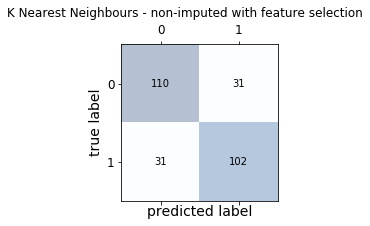

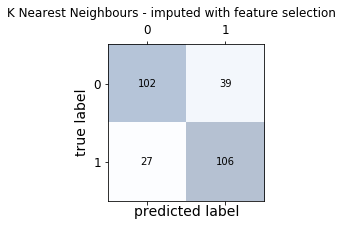

In [54]:
pipe_knn_optimal.fit(X_train_2, y_train_2)
pipe_knn_optimal_imputed.fit(X_train_2_imputed, y_train_2_imputed)

print('-------')
print('With dropped values')
y_pred_2 = pipe_knn_optimal.predict(X_test_2)
confmat = confusion_matrix(y_true=y_test_2, y_pred=y_pred_2)
print(confmat)

print('-------')
print('Imputed values')
y_pred_2_imputed = pipe_knn_optimal_imputed.predict(X_test_2_imputed)
confmat_imputed = confusion_matrix(y_true=y_test_2_imputed, y_pred=y_pred_2_imputed)
print(confmat_imputed)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.suptitle('K Nearest Neighbours - non-imputed with feature selection', y=1, va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat_imputed, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_imputed.shape[0]):
    for j in range(confmat_imputed.shape[1]):
        ax.text(x=j, y=i, s=confmat_imputed[i, j], va='center', ha='center')

plt.suptitle('K Nearest Neighbours - imputed with feature selection', y=1, va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()

plt.show()

In [55]:
# Generate the Precision, Recall and F1 scores for the model

pipe_knn_optimal.fit(X_train_2, y_train_2)
accuracy = pipe_knn_optimal.score(X_test_2, y_test_2)
print ("Accuracy for KNN non-imputed with feature selection = " + str((accuracy.round(3))))

y_pred = pipe_knn_optimal.predict(X_test_2)
print('Precision for KNN non-imputed with feature selection: %.3f' % precision_score(y_true=y_test_2, y_pred=y_pred))
print('Recall for KNN non-imputed with feature selection: %.3f' % recall_score(y_true=y_test_2, y_pred=y_pred))
print('F1 for KNN non-imputed with feature selection: %.3f' % f1_score(y_true=y_test_2, y_pred=y_pred))

Accuracy for KNN non-imputed with feature selection = 0.774
Precision for KNN non-imputed with feature selection: 0.767
Recall for KNN non-imputed with feature selection: 0.767
F1 for KNN non-imputed with feature selection: 0.767


In [56]:
# Generate the Precision, Recall and F1 scores for the model

pipe_knn_optimal_imputed.fit(X_train_2_imputed, y_train_2_imputed)
accuracy_imputed = pipe_knn_optimal_imputed.score(X_test_2_imputed, y_test_2_imputed)
print ("Accuracy for KNN imputed with feature selection = " + str((accuracy_imputed.round(3))))

y_pred = pipe_knn_optimal_imputed.predict(X_test_2_imputed)
print('Precision for KNN imputed with feature selection: %.3f' % precision_score(y_true=y_test_2_imputed, y_pred=y_pred))
print('Recall for KNN imputed with feature selection: %.3f' % recall_score(y_true=y_test_2_imputed, y_pred=y_pred))
print('F1 for KNN imputed with feature selection: %.3f' % f1_score(y_true=y_test_2_imputed, y_pred=y_pred))

Accuracy for KNN imputed with feature selection = 0.759
Precision for KNN imputed with feature selection: 0.731
Recall for KNN imputed with feature selection: 0.797
F1 for KNN imputed with feature selection: 0.763


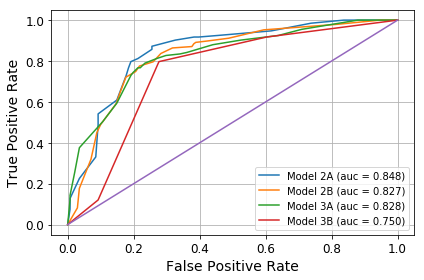

In [57]:
# Create graph to show ROC and calucalte the AUC to further evaluate both models


y_pred = pipe_knn_optimal.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % ("Model 2A", roc_auc))

y_pred = pipe_knn_optimal.fit(X_train_imputed, y_train_imputed).predict_proba(X_test_imputed)[:, 1]
fpr, tpr, thresholds_2 = roc_curve(y_true=y_test_imputed, y_score=y_pred)
roc_auc_2 = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % ("Model 2B", roc_auc_2))

y_pred = pipe_knn_optimal.fit(X_train_2, y_train_2).predict_proba(X_test_2)[:, 1]
fpr_opt, tpr_opt, thresholds_3 = roc_curve(y_true=y_test_2, y_score=y_pred)
roc_auc_3 = auc(x=fpr_opt, y=tpr_opt)
plt.plot(fpr_opt, tpr_opt, label='%s (auc = %0.3f)' % ("Model 3A", roc_auc_3))

y_pred = pipe_knn_optimal_imputed.fit(X_train_2_imputed, y_train_2_imputed).predict_proba(X_test_2_imputed)[:, 1]
fpr_opt, tpr_opt, thresholds_4 = roc_curve(y_true=y_test_2_imputed, y_score=y_pred)
roc_auc_4 = auc(x=fpr_opt, y=tpr_opt)
plt.plot(fpr_opt, tpr_opt, label='%s (auc = %0.3f)' % ("Model 3B", roc_auc_4))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1]) 
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

In [58]:
# Cross validation

pipe_knn_optimal = Pipeline([('mms', MinMaxScaler()), ('pca', PCA(random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k, weights='uniform', metric='euclidean'))])

pipe_knn_optimal_imputed = Pipeline([('mms', MinMaxScaler()), ('pca', PCA(random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=optimal_k_imputed, weights='uniform', metric='euclidean'))])



from sklearn.model_selection import cross_val_score
tests = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
knn_test_results_2 = []

print("For feature selected data with dropped missing values")
print("-----------------------------------------------------")
for test in tests:
    knn_scores_2 = cross_val_score(pipe_knn_optimal, X_2, y_2, cv=5, scoring=test)
    knn_test_results_2.append(knn_scores_2)
    print("5-fold " + test + " :  %0.3f (+/- %0.2f)" % (knn_scores_2.mean(), knn_scores_2.std() * 2))

    
knn_test_results_2_imputed = []

print("=====================================================")
print("For feature selected data with imputed")
print("-----------------------------------------------------")

for test in tests:
    knn_scores_2_imputed = cross_val_score(pipe_knn_optimal_imputed, X_2_imputed, y_2_imputed, cv=5, scoring=test)
    knn_test_results_2_imputed.append(knn_scores_2_imputed)
    print("5-fold " + test + " :  %0.3f (+/- %0.2f)" % (knn_scores_2_imputed.mean(), knn_scores_2_imputed.std() * 2))

    

For feature selected data with dropped missing values
-----------------------------------------------------
5-fold accuracy :  0.789 (+/- 0.06)
5-fold precision :  0.766 (+/- 0.08)
5-fold recall :  0.818 (+/- 0.09)
5-fold f1 :  0.790 (+/- 0.05)
5-fold roc_auc :  0.846 (+/- 0.06)
For feature selected data with imputed
-----------------------------------------------------
5-fold accuracy :  0.774 (+/- 0.09)
5-fold precision :  0.776 (+/- 0.11)
5-fold recall :  0.761 (+/- 0.17)
5-fold f1 :  0.765 (+/- 0.10)
5-fold roc_auc :  0.806 (+/- 0.09)
